<a href="https://colab.research.google.com/github/Ni7070/EkusheDatasetMaleFemaleHandwritingRecognizer/blob/main/Ekushe_Dataset_Male_Female_Handwriting_Recognizer_with_Deep_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import os
from os import path
import shutil
import glob

In [ ]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#taking csv files
female_digit = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/ekushCSV/Female/femaleDigits.csv")
male_digit = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/ekushCSV/Male/maleDigits.csv")

In [ ]:
#changing the label colums value for female 1, male 0
female_digit['label'] = 1
male_digit['label'] = 0

In [ ]:
#concating all labels 
female_label = female_digit['label']

male_label = male_digit['label']

labels = pd.concat([female_label, male_label],ignore_index=True)

In [ ]:
#concating all images
images = pd.concat([female_digit, male_digit],ignore_index=True)
images = images.drop(labels='label',axis=1)
print(images.shape)
print(images)
print(labels)
print(labels.shape)

In [ ]:
#normalizing and reshaping images
images = images/255.0
images = images.values.reshape(-1,28,28,1)

0
male writing


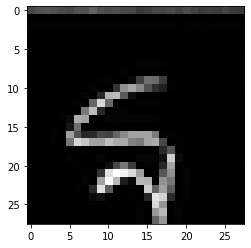

In [ ]:
#plotting a digit
import matplotlib.pyplot as plt 
import numpy as np

i = 30820
show_img = images[i].reshape(28, 28)
plt.imshow(show_img, cmap='gray')
print(labels[i])
if(labels[i]==1):
  print("female writing")
else:
  print("male writing")


In [ ]:
#split data into train:test = 90:10
from sklearn.model_selection import train_test_split
image_train, image_test, label_train, label_test = train_test_split(images, labels, test_size=0.1)
print(image_test)

In [ ]:
#creating dataset
train_dataset = list(zip(image_train, label_train))
test_dataset = list(zip(image_test, label_test))

#Settings 01:#

In [ ]:
# Hyperparameters
batch_size = 64
num_iters = 10000
input_dim = 28*28 # num_features = 784
num_hidden = 120
output_dim = 10

learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


train_dataset = list(zip(image_train, label_train))

test_dataset = list(zip(image_test, label_test))


num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(784, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.tanh = nn.Tanh()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.leaky_relu_1 = nn.LeakyReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_1 = nn.ReLU6()


        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        self.sigmoid = nn.Sigmoid()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ## 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.tanh(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.leaky_relu_1(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_1(out)

        ### 4th hidden layer 
        out  = self.linear_5(out)
        ### Non-linearity in 4th hidden layer
        out = self.sigmoid(out)
        
        # Linear layer (output)
        logits  = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return probas


model = NeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)
'''
TRAIN THE MODEL
'''
iter = 0
iteration_loss = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float()) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.9038654565811157. Accuracy: 58.64417774894583
Iteration: 1000. Loss: 1.8827110528945923. Accuracy: 59.6496918585793
Iteration: 1500. Loss: 1.8789058923721313. Accuracy: 60.201102821926696
Iteration: 2000. Loss: 1.7878327369689941. Accuracy: 59.29289652935452
Iteration: 2500. Loss: 1.8393644094467163. Accuracy: 59.584819980538434
Iteration: 3000. Loss: 1.9517732858657837. Accuracy: 62.244566980214074
Iteration: 3500. Loss: 1.760406255722046. Accuracy: 60.10379500486539
Iteration: 4000. Loss: 1.782341718673706. Accuracy: 61.66072007784626
Iteration: 4500. Loss: 1.8069168329238892. Accuracy: 61.758027894907556
Iteration: 5000. Loss: 1.9205055236816406. Accuracy: 61.53097632176451
Iteration: 5500. Loss: 1.8346781730651855. Accuracy: 62.40674667531625
Iteration: 6000. Loss: 1.9451041221618652. Accuracy: 60.00648718780409
Iteration: 6500. Loss: 1.8043040037155151. Accuracy: 61.790463833927994
Iteration: 7000. Loss: 1.909275770187378. Accuracy: 61.822899772948425
Itera

[1.9038654565811157, 1.8827110528945923, 1.8789058923721313, 1.7878327369689941, 1.8393644094467163, 1.9517732858657837, 1.760406255722046, 1.782341718673706, 1.8069168329238892, 1.9205055236816406, 1.8346781730651855, 1.9451041221618652, 1.8043040037155151, 1.909275770187378, 1.808551549911499, 1.7962114810943604, 1.843078374862671, 1.760352611541748, 1.7305388450622559]


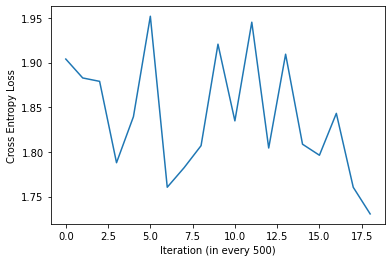

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

#Settings 02:#

In [ ]:
# Hyperparameters 
batch_size = 80
num_iters = 6000
input_dim = 28*28 # num_features = 784
num_hidden = 50
output_dim = 10

learning_rate = 0.005

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


train_dataset = list(zip(image_train, label_train))

test_dataset = list(zip(image_test, label_test))


num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   # It's better to shuffle the whole training dataset! 

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer
        self.linear_1 = nn.Linear(input_size, num_hidden)

        ### Non-linearity
        self.relu = nn.ReLU6()

        ### Output layer
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        # Linear layer
        out  = self.linear_1(x)
        # Non-linearity
        out = self.relu(out)
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

model = NeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

'''
TRAIN THE MODEL
'''
iter = 0
iteration_loss = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float()) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.6791590452194214. Accuracy: 59.941615309763215
Iteration: 1000. Loss: 0.6645830273628235. Accuracy: 61.88777165098929
Iteration: 1500. Loss: 0.6402636170387268. Accuracy: 62.082387285111906
Iteration: 2000. Loss: 0.6190427541732788. Accuracy: 61.07687317547843
Iteration: 2500. Loss: 0.6426941156387329. Accuracy: 61.43366850470321
Iteration: 3000. Loss: 0.64045250415802. Accuracy: 62.179695102173206
Iteration: 3500. Loss: 0.5313791036605835. Accuracy: 61.790463833927994
Iteration: 4000. Loss: 0.6320759057998657. Accuracy: 62.925721699643205
Iteration: 4500. Loss: 0.542967677116394. Accuracy: 61.758027894907556
Iteration: 5000. Loss: 0.5392397046089172. Accuracy: 62.79597794356147
Iteration: 5500. Loss: 0.5244557857513428. Accuracy: 62.244566980214074


[0.6791590452194214, 0.6645830273628235, 0.6402636170387268, 0.6190427541732788, 0.6426941156387329, 0.64045250415802, 0.5313791036605835, 0.6320759057998657, 0.542967677116394, 0.5392397046089172, 0.5244557857513428]


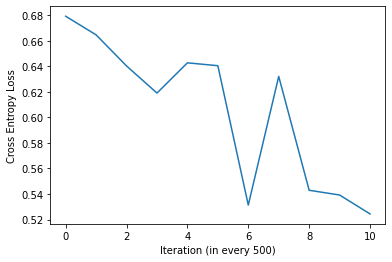

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

#Settings:03#

In [ ]:
# Hyperparameters
batch_size = 80
num_iters = 10000
input_dim = 28*28 # num_features = 784
num_hidden = 64
output_dim = 10

learning_rate = 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


train_dataset = list(zip(image_train, label_train))

test_dataset = list(zip(image_test, label_test))


num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer:
        self.linear_1 = nn.Linear(input_size, 512)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.Tanh()

        ### 2nd hidden layer:
        self.linear_2 = nn.Linear(512, 256)
        ### Non-linearity in 2nd hidden layer
        self.leaky_relu_1 = nn.LeakyReLU()

        ### 3rd hidden layer: 
        self.linear_3 = nn.Linear(256, 128)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU6()

        self.linear_4 = nn.Linear(128, 64)
        self.sigmoid = nn.Sigmoid()

        ### Output layer: 
        self.linear_out = nn.Linear(64, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.leaky_relu_1(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 4th hidden layer
        out = self.sigmoid(out)
        
        # Linear layer (output)
        logits  = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return probas


model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

'''
TRAIN THE MODEL
'''
iter = 0
iteration_loss = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float()) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.8505198955535889. Accuracy: 57.83327927343497
Iteration: 1000. Loss: 1.9314582347869873. Accuracy: 60.33084657800843
Iteration: 1500. Loss: 1.8860054016113281. Accuracy: 59.422640285436266
Iteration: 2000. Loss: 1.912601113319397. Accuracy: 60.52546221213104
Iteration: 2500. Loss: 1.7948334217071533. Accuracy: 61.012001297437564
Iteration: 3000. Loss: 1.8930346965789795. Accuracy: 61.1417450535193
Iteration: 3500. Loss: 1.8324543237686157. Accuracy: 61.56341226078495
Iteration: 4000. Loss: 1.8578836917877197. Accuracy: 60.10379500486539
Iteration: 4500. Loss: 1.8828725814819336. Accuracy: 61.69315601686669
Iteration: 5000. Loss: 1.8182437419891357. Accuracy: 61.85533571196886
Iteration: 5500. Loss: 1.817087173461914. Accuracy: 61.69315601686669
Iteration: 6000. Loss: 1.755921721458435. Accuracy: 62.21213104119364
Iteration: 6500. Loss: 1.8391952514648438. Accuracy: 61.822899772948425
Iteration: 7000. Loss: 1.7613853216171265. Accuracy: 61.95264352903016
Iteratio

[1.8505198955535889, 1.9314582347869873, 1.8860054016113281, 1.912601113319397, 1.7948334217071533, 1.8930346965789795, 1.8324543237686157, 1.8578836917877197, 1.8828725814819336, 1.8182437419891357, 1.817087173461914, 1.755921721458435, 1.8391952514648438, 1.7613853216171265, 1.8369462490081787, 1.779670000076294, 1.858557939529419, 1.8366073369979858, 1.8243459463119507]


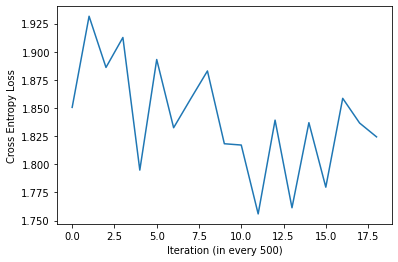

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

#Settings 04:#

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Hyperparameters
batch_size = 100
num_iters = 4000
input_dim = 28*28 # num_features = 784
num_hidden = 160
output_dim = 10

learning_rate = 0.001
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


train_dataset = list(zip(image_train, label_train))

test_dataset = list(zip(image_test, label_test))


num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class NeuralNetworkModel(nn.Module):
  def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.leaky_relu_1 = nn.LeakyReLU()
        
        ### 2nd hidden layer: 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.sigmoid = nn.Sigmoid()

        ### Output layer: 
        self.linear_out = nn.Linear(num_hidden, num_classes)
      

  def forward(self, x):
      ### 1st hidden layer
      out  = self.linear_1(x)
      ### Non-linearity in 1st hidden layer
      out = self.leaky_relu_1(out)

      ### 2nd hidden layer
      out  = self.linear_4(out)
      ### Non-linearity in 2nd hidden layer
      out = self.sigmoid(out)
      
      probas  = self.linear_out(out)
      return probas


  

model = NeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

iter = 0
iteration_loss = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float()) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.6491038799285889. Accuracy: 60.55789815115148
Iteration: 1000. Loss: 0.6354926228523254. Accuracy: 58.83879338306844
Iteration: 1500. Loss: 0.6372236013412476. Accuracy: 61.466104443723644
Iteration: 2000. Loss: 0.6268097162246704. Accuracy: 62.69867012650016
Iteration: 2500. Loss: 0.6447554230690002. Accuracy: 62.95815763866364
Iteration: 3000. Loss: 0.5652639269828796. Accuracy: 62.179695102173206
Iteration: 3500. Loss: 0.5028883218765259. Accuracy: 62.76354200454103


[0.6491038799285889, 0.6354926228523254, 0.6372236013412476, 0.6268097162246704, 0.6447554230690002, 0.5652639269828796, 0.5028883218765259]


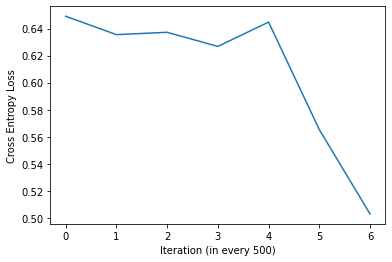

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

# **Assignment #2**#
 **ID:16.02.04.070**
  **Problem 1**
  -I have tried many settings but the highest accuracy was between 60-63%. So, i changed the model, optimizers, and tried to bring variations in the settings. These are the best 4 results I could get from my different types of settigns.
- **1st Settings:**
First I have tried with 4 layers (tanh->leakyReLU->ReLU6->Sigmoid) withAdmax optimizer with 120 hidden layer dimensions.
- **2nd Settings:**
Tried this settings with one hidden layer of ReLU6.
- **3rd Settings:**
The model was like the first settings but here I varied the hidden layer dimension from 512->256->128->64.
- **4th Settings:**
Worked with two layer (leakyReLU->Sigmoid) with Adam optimizer.




No.|batch_size | num_iters | learning rate|optimizer|hidden layer Dim|Accuracy
---|---|---|---|---|---|---|
1|64|10,000|0.001|Adagrad|120|62.504054492377556%
2|80|6,000|0.005|Adamax|50|62.244566980214074%
3|80|10,000|0.001|Adamax|(varied)|62.11482322413234%
4|100|4000|0.001|Adam|160|62.76354200454103%


In [ ]:
root_path = '/content/gdrive/MyDrive/Colab Notebooks/pickle Files'

In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'ekushe_logisticR12.pkl') 

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'ekushe_logisticR12.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded
